In [31]:
import pandas as pd
import numpy as np
import pycountry
import plotly.express as px
import plotly.graph_objects as go

In [32]:
df_cnfrmd = pd.read_csv("time_series_2019_ncov_confirmed.csv")
df_cnfrmd = df_cnfrmd.groupby("Country/Region").sum()
df_cnfrmd.reset_index(inplace=True) # get country as col
df_cnfrmd["Country/Region"].replace([ # rename to match pycountry standard
                                     "Macau",
                                     "Russia",
                                     "South Korea", 
                                     "Taiwan", 
                                     "UK",
                                     "US",
                                     "Vietnam"
                                     
                                    ],
                                    [
                                     "Macao",
                                     "Russian Federation",
                                     "Korea, Republic of",
                                     "Taiwan, Province of China",
                                     "United Kingdom",
                                     "United States",
                                     "Viet Nam"
                                     
                                    ], inplace=True)

df_cnfrmd.drop(["Lat","Long"], axis=1, inplace=True) # not needed

sec2_df = df_cnfrmd.iloc[:,1:] # 2nd section containing only confirmed counts
#sec2_df.columns = ["timestamp "+col for col in list(sec2_df.columns)] # format names

sec1_df = pd.DataFrame(df_cnfrmd.iloc[:,0]) # 1st section containing location data
def getCountryCode(x):
    # get alph3 encoding to match plotly standard
    try:
        c = pycountry.countries.get(name=x)
        return c.alpha_3
    except Exception as e:
        print(e)
        pass
    
sec1_df["Country_Code"] = sec1_df["Country/Region"].apply(getCountryCode)
sec1_df.columns = ["Country", "Country_Code"]
df_cnfrmd = pd.concat([sec1_df, sec2_df],axis=1) # concat back two sections

df_cnfrmd.dropna(axis=0, inplace=True)
df_cnfrmd.reset_index(inplace=True, drop=True)

# melt (i.e: wide to long function)
df_cnfrmd = pd.melt(df_cnfrmd, id_vars=["Country","Country_Code"],var_name="Time_Stamp", value_name="Cases")

print(df_cnfrmd.shape)
df_cnfrmd.to_csv("df_cnfrmd_proc.csv",index=False)
df_cnfrmd.head(3)



'NoneType' object has no attribute 'alpha_3'
'NoneType' object has no attribute 'alpha_3'
(972, 4)


,Country,Country_Code,Time_Stamp,Cases
0,Australia,AUS,1/21/20 22:00,0.0
1,Belgium,BEL,1/21/20 22:00,0.0
2,Cambodia,KHM,1/21/20 22:00,0.0


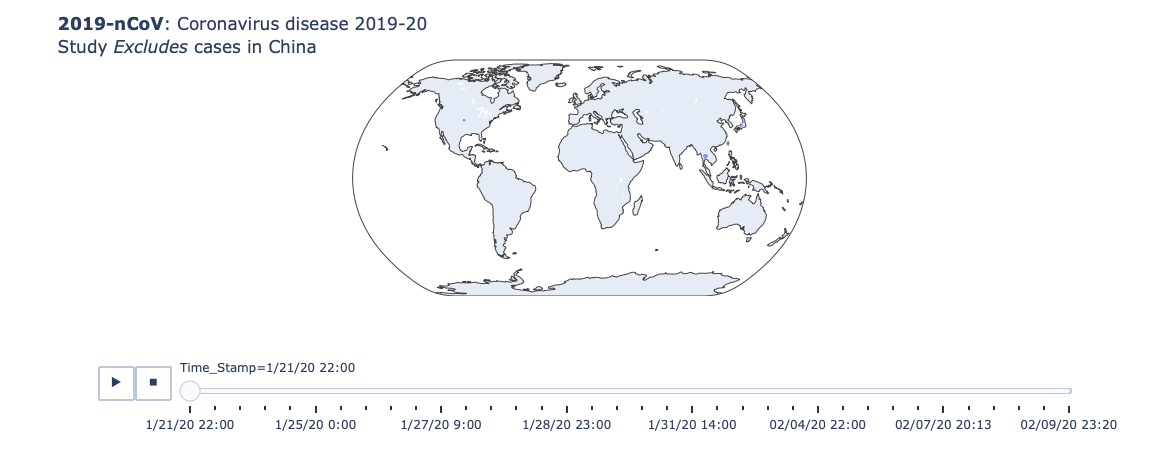

In [33]:
df_cnfrmd = pd.read_csv("df_cnfrmd_proc.csv")
df = px.data.gapminder()
fig = px.scatter_geo(df_cnfrmd, locations="Country_Code",
                     hover_name="Country", size="Cases",
                     animation_frame="Time_Stamp",
                     projection="natural earth")

fig.update_layout(
        title = go.layout.Title(
        text = '<b>2019-nCoV</b>: Coronavirus disease 2019-20<br>Study <i>Excludes</i> cases in China'),
        showlegend = True,

    )
fig.show()

### Plotly in Flask, Python:
Save processed dataframe, and render the plot as in ```app.py```
### Alternative way to include plotly figures in Flask:
---
First, in jupyter notebook, convert the figure to JSON:
```python
import json
import plotly
import pickle

graphJSON = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder) # convert figure to json
pickle.dump(graphJSON, open('json.pkl', 'wb')) # save json file via pickle
```
---

In flask, app.py:
```python import pickle
jsonplot = pickle.load( open( "json.pkl", "rb" ) )
def index():
    return render_template('index.html', plot=jsonplot)
```